In [11]:
#  CLAIM: Model performance declines on short proteins.

In [14]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.classifier import Classifier
import matplotlib as mpl 
from src.tools import MMSeqs 
from utils import * 

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model_name = 'model_v2'
model = Classifier.load('../models/model_v2.pkl')

annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)
annotated_results_df['nested'] = annotated_results_df.category.str.contains('nested')

spurious_ids = annotated_results_df[annotated_results_df.category.str.contains('error') | (annotated_results_df.category == 'fragment')].index.values
real_ids = annotated_results_df[~annotated_results_df.category.str.contains('error') & (annotated_results_df.category != 'fragment')].index.values
print('Num. mislabeled real sequences:', len(spurious_ids))
print('Num. misclassified real sequences:', len(real_ids))

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df = apply_thresholds(results_df)
results_df['length'] = results_df.seq.apply(len)
results_df['nested'] = results_df.index.isin(annotated_results_df[annotated_results_df.nested].index)
results_df.loc[spurious_ids, 'label'] = 0 # Correct the labels of the mislabeled SwissProt sequences.

print('Num. misclassified smORFs:', (results_df.loc[real_ids].length < 100).sum(), f'({get_percent((results_df.loc[real_ids].length < 100).sum(), len(spurious_ids))})')
print('Num. misclassified nested smORFs:', ((results_df.loc[real_ids].length < 100) & (results_df.nested)).sum())


Num. mislabeled real sequences: 128
Num. misclassified real sequences: 172
Num. misclassified smORFs: 125 (97.66%)
Num. misclassified nested smORFs: 4


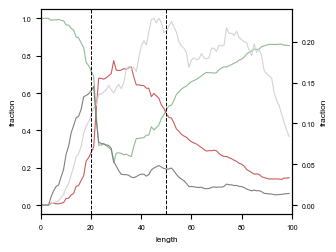

In [ ]:
# Can't just correlate sequence length and model output, as the spurious-labeled sequences have a distribution that 
# has a peak around __ amino acids; length bias would show that sequences closest in length to this peak are more likely to be 
# classified as spurious. 

def figure_1(results_df:pd.DataFrame, path:str='../figures/results-1.4_figure-1.pdf'):

    fig, ax = get_figure() 

    figure_df = results_df[results_df.length < 100].copy()
    figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
    figure_df['misclassified'] = (figure_df.model_label != figure_df.label) # & (figure_df.model_label != 'uncertain')

    delta = 8

    ax_df = pd.DataFrame(index=pd.Series(np.arange(100), name='length'))
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta))).sum() for length in ax_df.index])
    for label, df in figure_df.groupby('label'):
        counts = np.array([((df.length < (length + delta)) & (df.length > (length - delta))).sum(axis=None) for length in ax_df.index])
        ax_df[f'fraction'] = counts / totals
        sns.lineplot(data=ax_df, x='length', y='fraction', color=palette[label], ax=ax)

    ax = ax.twinx()

    counts = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta)) & figure_df.misclassified).sum(axis=None) for length in ax_df.index])
    totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta))).sum(axis=None) for length in ax_df.index])
    ax_df[f'fraction'] = counts / figure_df.misclassified.sum()
    sns.lineplot(data=ax_df, x='length', y='fraction', ax=ax, color='lightgray')

    ax_df[f'fraction'] = counts / totals
    sns.lineplot(data=ax_df, x='length', y='fraction', ax=ax, color='gray')

    ax.set_xlim(xmin=0, xmax=100)
    ax.axvline(50, ls='--', lw=0.7, color='black')
    ax.axvline(20, ls='--', lw=0.7, color='black')

    # text = ''
    # text += get_text('real < 25', ((figure_df.label == 'real') & (figure_df.length < 25)).sum(), len(figure_df))
    # text += get_text('spurious < 25', ((figure_df.label == 'spurious') & (figure_df.length < 25)).sum(), len(figure_df))
    # ax_b.text(0.55, 0.8, text, transform=ax_b.transAxes)

    save_figure(fig, path)

figure_1(results_df)


In [ ]:
min_length, max_length = 0, 100

# Results from sequence clustering at 80% identity with MMseqs.
cluster_df = MMSeqs.load_cluster('../data/results/dataset_cluster_mmseqs.tsv')

df = results_df.copy()
df = df[(df.length > min_length) & (df.length < max_length)].copy()
df['label'] = df.label.map({1:'real', 0:'spurious', 'real':'real', 'spurious':'spurious'})
df['cluster_id'] = df.index.map(cluster_df.cluster_id)
df['cluster_size'] = df.cluster_id.map(cluster_df.groupby('cluster_id').size())
df['misclassified'] = (df.model_label != df.label) & (results_df.model_label != 'uncertain')
df['false_negative'] = (df.model_label == 'spurious') & (df.label == 'real') & (results_df.model_label != 'uncertain')
df['singleton'] = df.cluster_size == 1

n_real = (df.label == 'real').sum()
n_spurious = (df.label == 'spurious').sum()

print(f'Num. in length range {min_length}-{max_length}:', len(df), f'({get_percent(len(df), (results_df.length < 100).sum())})')
print(f'Num. real in length range {min_length}-{max_length}:', n_real, f'({get_percent(n_real, len(df))})')
print('Num. misclassified:', df.misclassified.sum(), f'({get_percent(df.misclassified.sum(), len(df))})')
print('Num. false negative:', df.false_negative.sum(), f'({get_percent(df.false_negative.sum(), len(df))})')
print('Num. in singleton clusters:', df.singleton.sum(), f'({get_percent(df.singleton.sum(), len(df))})')
print('Num. real in singleton clusters:', df[df.model_label == 'real'].cluster_id.nunique())
print('Num. misclassified in singleton cluster:', (df.misclassified & df.singleton).sum())
print('Num. false negative in singleton cluster:', (df.false_negative & df.singleton).sum())
print('Num. false negative in a two-sequence cluster:', (df.false_negative & (df.cluster_size == 2)).sum())

Num. in length range 0-100: 28878 (100.00%)
Num. real in length range 0-100: 19748 (68.38%)
Num. misclassified: 128 (0.44%)
Num. false negative: 125 (0.43%)
Num. in singleton clusters: 12120 (41.97%)
Num. real in singleton clusters: 9644
Num. misclassified in singleton cluster: 108
Num. false negative in singleton cluster: 105
Num. false negative in a two-sequence cluster: 14
